In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
# Load training and validation data
train_data = ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)

In [6]:
val_data = ImageFolder(root=val_dir, transform=transform)
valloader = DataLoader(val_data, batch_size=32, shuffle=False)

In [7]:
# Initialize the ResNet model
model = models.resnet101(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
number_of_epochs = 30

In [10]:
# Initialize a dictionary to store metrics
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': []  # Ensure you add functionality to calculate precision if needed
}

In [11]:
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / total_train
    epoch_train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(epoch_train_loss)
    history['train_accuracy'].append(epoch_train_accuracy)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / total_val
    val_accuracy = 100 * correct_val / total_val
    val_precision = precision_score(all_labels, all_preds, average='macro')
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_precision'].append(val_precision)

    print(f'Epoch {epoch + 1}/{number_of_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_accuracy:.2f}%, Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Validation Precision: {val_precision:.4f}')

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
Train Loss: 0.6990, Accuracy: 51.03%, Loss: 0.9706, Val Accuracy: 42.86%, Validation Precision: 0.2143


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/30
Train Loss: 0.6779, Accuracy: 59.79%, Loss: 0.7747, Val Accuracy: 42.86%, Validation Precision: 0.2143
Epoch 3/30
Train Loss: 0.5254, Accuracy: 79.38%, Loss: 0.7132, Val Accuracy: 39.29%, Validation Precision: 0.3667
Epoch 4/30
Train Loss: 0.4161, Accuracy: 93.81%, Loss: 0.7692, Val Accuracy: 46.43%, Validation Precision: 0.7222


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/30
Train Loss: 0.3230, Accuracy: 93.81%, Loss: 0.9649, Val Accuracy: 42.86%, Validation Precision: 0.2143
Epoch 6/30
Train Loss: 0.2221, Accuracy: 93.81%, Loss: 1.0899, Val Accuracy: 50.00%, Validation Precision: 0.7308
Epoch 7/30
Train Loss: 0.1432, Accuracy: 99.48%, Loss: 0.6629, Val Accuracy: 67.86%, Validation Precision: 0.7339
Epoch 8/30
Train Loss: 0.1131, Accuracy: 100.00%, Loss: 0.6837, Val Accuracy: 71.43%, Validation Precision: 0.7556
Epoch 9/30
Train Loss: 0.0530, Accuracy: 100.00%, Loss: 0.9764, Val Accuracy: 64.29%, Validation Precision: 0.7727
Epoch 10/30
Train Loss: 0.0846, Accuracy: 98.45%, Loss: 0.5418, Val Accuracy: 75.00%, Validation Precision: 0.7462
Epoch 11/30
Train Loss: 0.1920, Accuracy: 93.81%, Loss: 1.3694, Val Accuracy: 46.43%, Validation Precision: 0.5533
Epoch 12/30
Train Loss: 0.2678, Accuracy: 88.66%, Loss: 0.7514, Val Accuracy: 57.14%, Validation Precision: 0.6250
Epoch 13/30
Train Loss: 0.2646, Accuracy: 88.66%, Loss: 0.9607, Val Accuracy: 53.57

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/30
Train Loss: 0.0603, Accuracy: 98.97%, Loss: 2.5819, Val Accuracy: 42.86%, Validation Precision: 0.2143
Epoch 18/30
Train Loss: 0.2425, Accuracy: 91.75%, Loss: 2.2062, Val Accuracy: 39.29%, Validation Precision: 0.3667
Epoch 19/30
Train Loss: 0.4377, Accuracy: 84.54%, Loss: 0.7708, Val Accuracy: 60.71%, Validation Precision: 0.5963


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/30
Train Loss: 0.4117, Accuracy: 82.99%, Loss: 1.1445, Val Accuracy: 57.14%, Validation Precision: 0.2857
Epoch 21/30
Train Loss: 0.2535, Accuracy: 90.72%, Loss: 1.3559, Val Accuracy: 60.71%, Validation Precision: 0.7963
Epoch 22/30
Train Loss: 0.2021, Accuracy: 93.30%, Loss: 0.7237, Val Accuracy: 64.29%, Validation Precision: 0.6333
Epoch 23/30
Train Loss: 0.0888, Accuracy: 97.94%, Loss: 1.4825, Val Accuracy: 60.71%, Validation Precision: 0.7609
Epoch 24/30
Train Loss: 0.1426, Accuracy: 94.33%, Loss: 2.7855, Val Accuracy: 50.00%, Validation Precision: 0.7308
Epoch 25/30
Train Loss: 0.0955, Accuracy: 97.42%, Loss: 1.6972, Val Accuracy: 64.29%, Validation Precision: 0.7727
Epoch 26/30
Train Loss: 0.0413, Accuracy: 99.48%, Loss: 1.5050, Val Accuracy: 64.29%, Validation Precision: 0.7727
Epoch 27/30
Train Loss: 0.0498, Accuracy: 98.45%, Loss: 2.3329, Val Accuracy: 60.71%, Validation Precision: 0.7609
Epoch 28/30
Train Loss: 0.1653, Accuracy: 93.30%, Loss: 0.8755, Val Accuracy: 64

In [12]:
file_name = f'Pth_Files/Resnet101_model_{number_of_epochs}.pth'

In [13]:
torch.save(model.state_dict(), file_name)

In [24]:
# Function to load the model
def load_model(file_name = f'Pth_Files/Resnet101_model_{number_of_epochs}.pth'):
    model = models.resnet101(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(file_name))
    model.to(device)
    model.eval()
    return model

In [25]:
from PIL import Image

# Function to preprocess and predict a new image
def predict_image(model, image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = train_data.classes[predicted[0]]
        
    return predicted_class

In [26]:
image_1 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_1.jpg"
image_2 = test_dir + "/poisonous/Amanita_excelsa/Amanita_excelsa_1.jpg"
image_3 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_2.jpg"

In [27]:
# Example usage
print(f'The imag_1 is predicted as class: {predict_image(load_model(), image_1)}')
print(f'The imag_2 is predicted as class: {predict_image(load_model(), image_2)}')
print(f'The imag_3 is predicted as class: {predict_image(load_model(), image_3)}')

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The imag_1 is predicted as class: poisonous
The imag_2 is predicted as class: edible
The imag_3 is predicted as class: poisonous


## Results

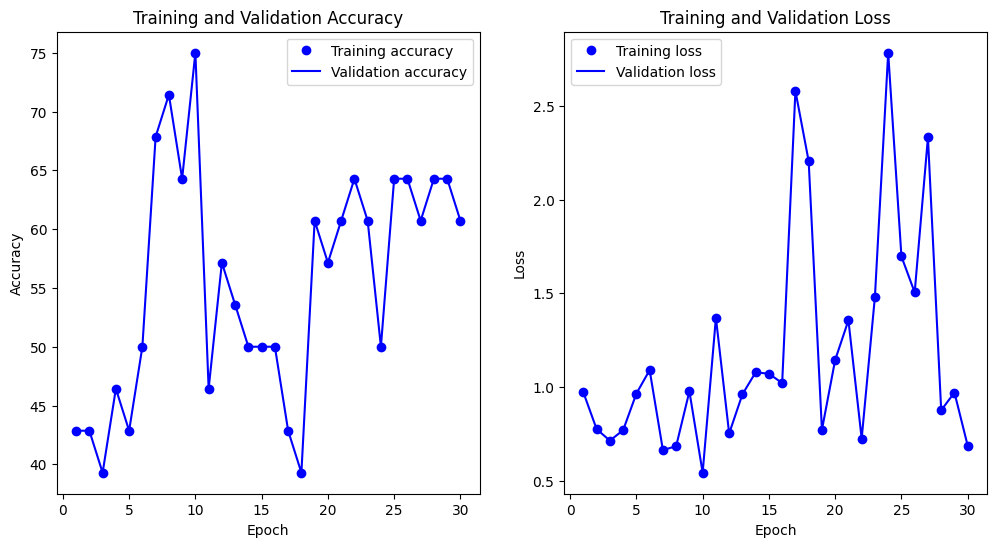

In [28]:
# Plot training & validation accuracy values
acc = history['val_accuracy']
val_acc = history['val_accuracy']
loss = history['val_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

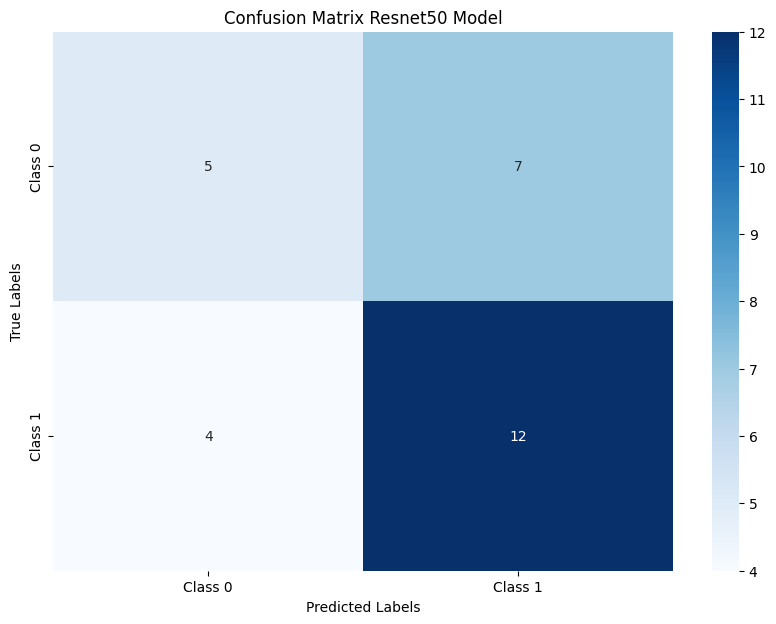

In [29]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix Resnet50 Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()